## The attached code is a run of the Neural Network Regressor model on data from booking without the addition of new features

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.p

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.6379293397025501, 'Train RMSE': 32.03645851043414, 'Train MSE': 1026.334673890768, 'Train MAE': 23.594011698877654, 'Test R2': 0.6242895011861551, 'Test RMSE': 32.886394694362366, 'Test MSE': 1081.5149559933852, 'Test MAE': 24.18339017565854, 'Train Size': 52558, 'Test Size': 22525, 'Best Parameters': {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


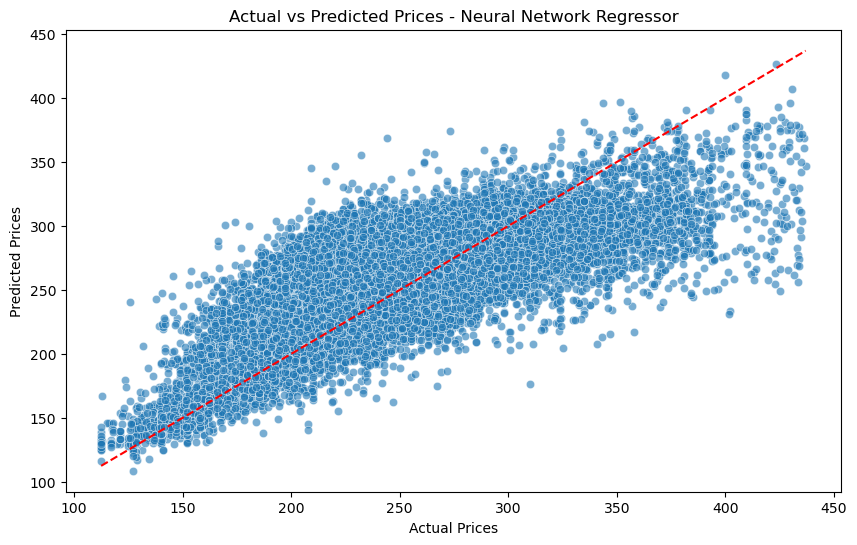

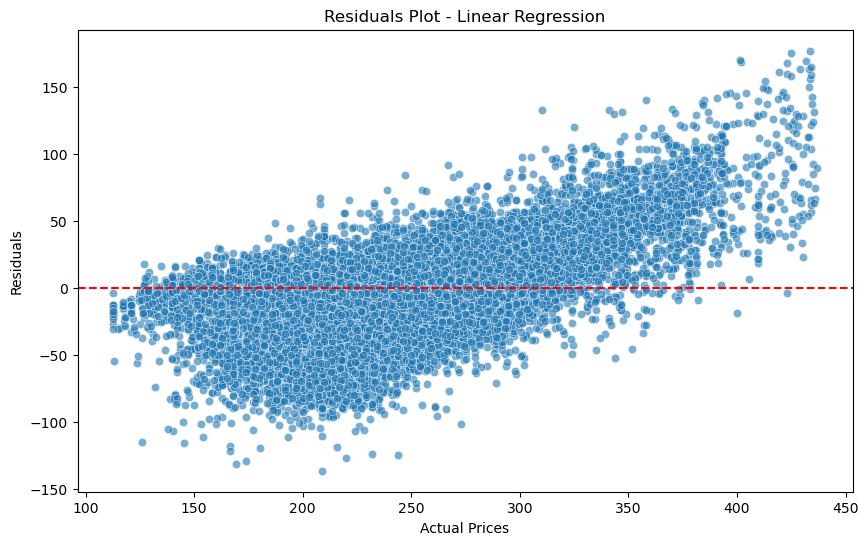

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./0507_cleaned_booking_hotels.csv')
df2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Remove the price column
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Linear Regression')
plt.show()


### ## The attached code is a run of the Neural Network Regressor model on booking data with additions of new features and after we have done one hot encoding for them (a period of the month - beginning, middle and end, day of the week of check in, day of the week of check out)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
42 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.p

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.9492578330013703, 'Train RMSE': 12.069466286819331, 'Train MSE': 145.67201644866842, 'Train MAE': 8.066934117829351, 'Test R2': 0.9478259534622506, 'Test RMSE': 12.261621723834773, 'Test MSE': 150.34736729841683, 'Test MAE': 8.266495863028762, 'Train Size': 52377, 'Test Size': 22448, 'Best Parameters': {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


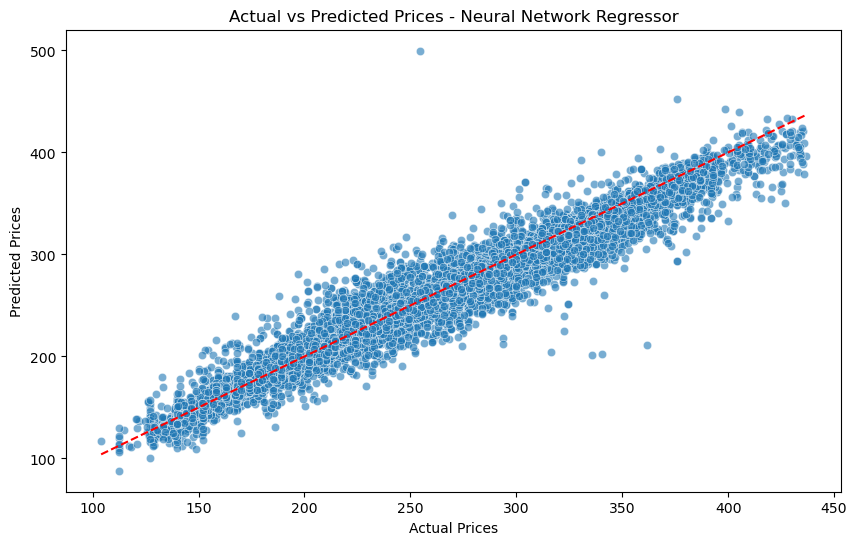

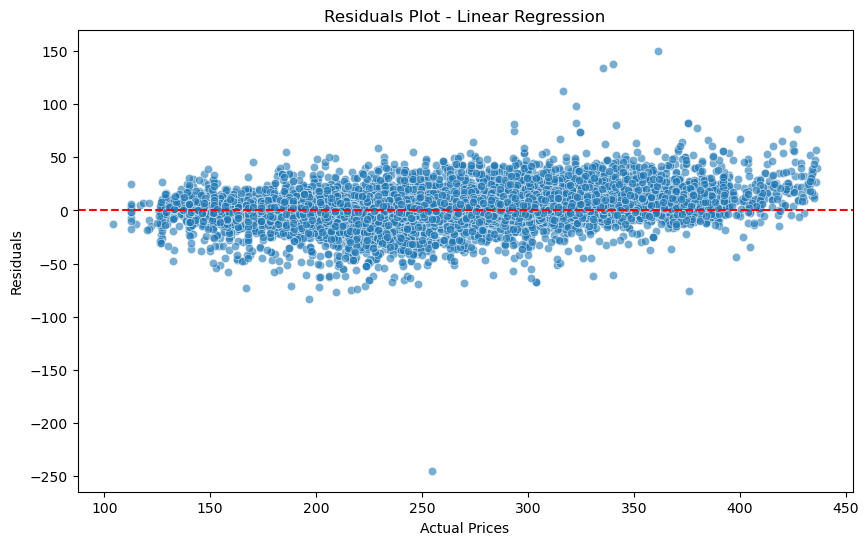

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./05_07_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv')
df2 = pd.read_csv('./25_06_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned_with_new_parameters_encoded.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')

    # Remove the price column
    if 'price' in df.columns:
        df = df.drop(columns=['price'])
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Linear Regression')
plt.show()



 ## summary and Conclusions :
In this notebook we ran an algorithm called Neural Network Regressor. In order to achieve optimal results, we performed a grid search for the best parameters in 5 main components of the model:
activation function - the activation function used by the neurons in the network
alpha- the disturbance rate which affects how much the model is updated in each iteration during training
hidden_layer_sizes - the number of neurons in each hidden layer in the network
learning_rate - check if the rate of the disturbance should change throughout the training time

Overall, it can be said that the model achieved excellent results
('Test R2': 0.9730775909684556, 'Test RMSE': 8.803321410996892, 'Test MSE': 77.4984678653163, 'Test MAE': 5.414021655129503 )
With a very nice balance between the training and the test, it can be assumed that there is no overtraining

The main takeaway is that the new features might not be adding significant new information that the model can leverage, possibly due to redundancy, low predictive power, or insufficient data variation. Additionally, feature engineering and interaction terms might be needed to make these new features more useful.

## The attached code is a run of the Neural Network Regressor model on data from booking without the addition of new features

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.p

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.9376195203605225, 'Train RMSE': 99.8146371957868, 'Train MSE': 9962.961798526547, 'Train MAE': 69.09840930287561, 'Test R2': 0.9356231097218244, 'Test RMSE': 102.3866610742331, 'Test MSE': 10483.02836592988, 'Test MAE': 70.68801736404473, 'Train Size': 52558, 'Test Size': 22525, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}}


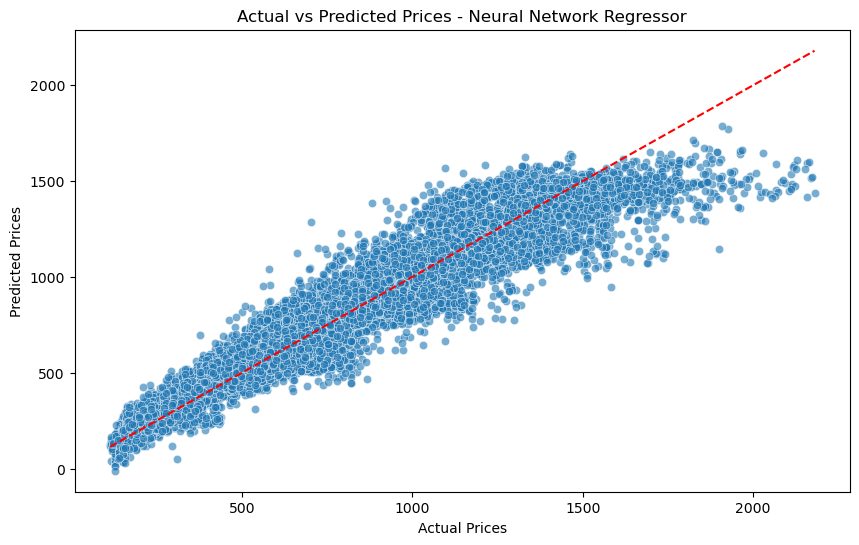

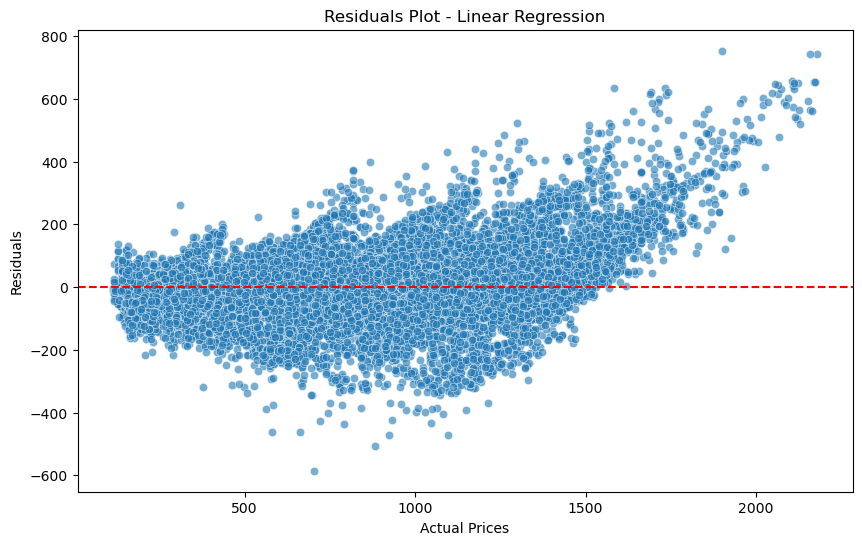

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./0507_cleaned_booking_hotels.csv')
df2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Remove the price column
if 'price_per_night' in df.columns:
    df = df.drop(columns=['price_per_night'])

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price'])
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Linear Regression')
plt.show()


### ## The attached code is a run of the Neural Network Regressor model on booking data with additions of new features and after we have done one hot encoding for them (a period of the month - beginning, middle and end, day of the week of check in, day of the week of check out)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ronro\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.p

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.983997375446029, 'Train RMSE': 51.52396842083962, 'Train MSE': 2654.719321831679, 'Train MAE': 34.260433352553854, 'Test R2': 0.9844855589578018, 'Test RMSE': 51.29259596977363, 'Test MSE': 2630.9304013184383, 'Test MAE': 34.32905863236407, 'Train Size': 52377, 'Test Size': 22448, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}}


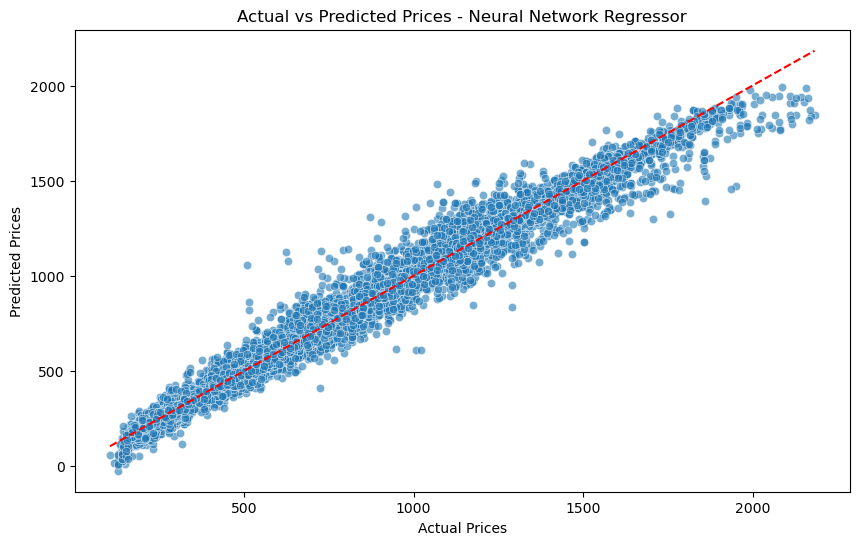

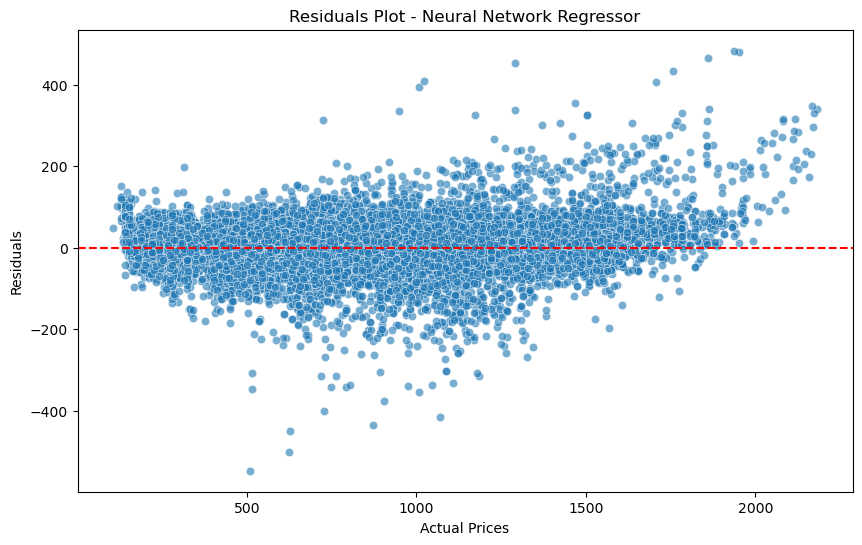

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./05_07_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv')
df2 = pd.read_csv('./25_06_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned_with_new_parameters_encoded.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to fill NaN values with the mean of the group
def fill_na_with_group_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

# Fill NaN values for the entire dataset
df = fill_na_with_group_mean(df)

# Remove the price_per_night column
if 'price_per_night' in df.columns:
    df = df.drop(columns=['price_per_night'])

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price'])
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - Neural Network Regressor')
plt.show()


C:\Users\ronro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


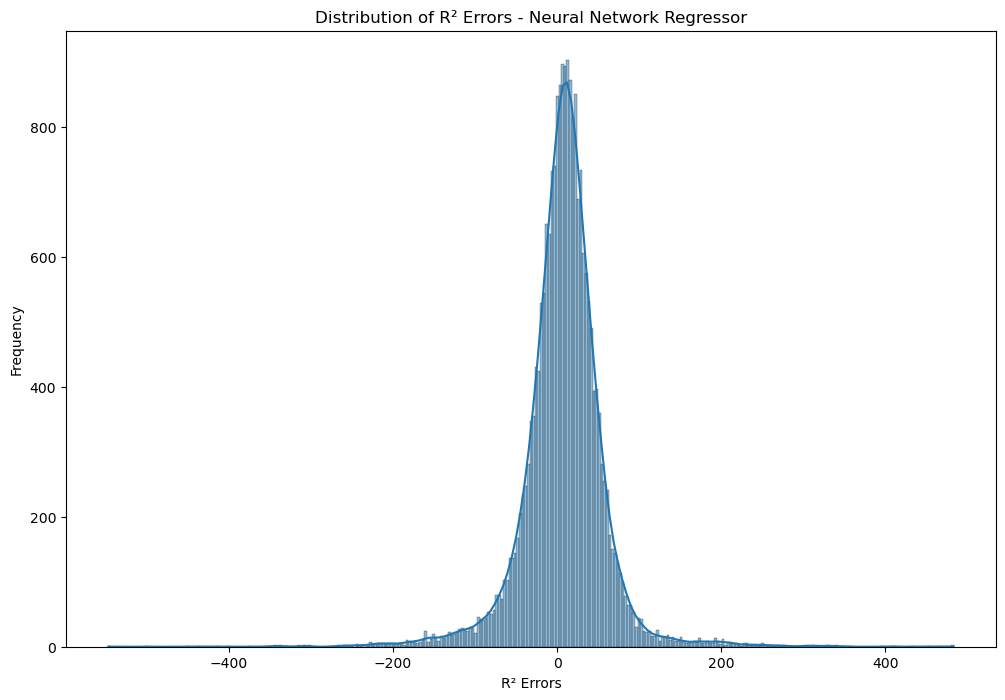

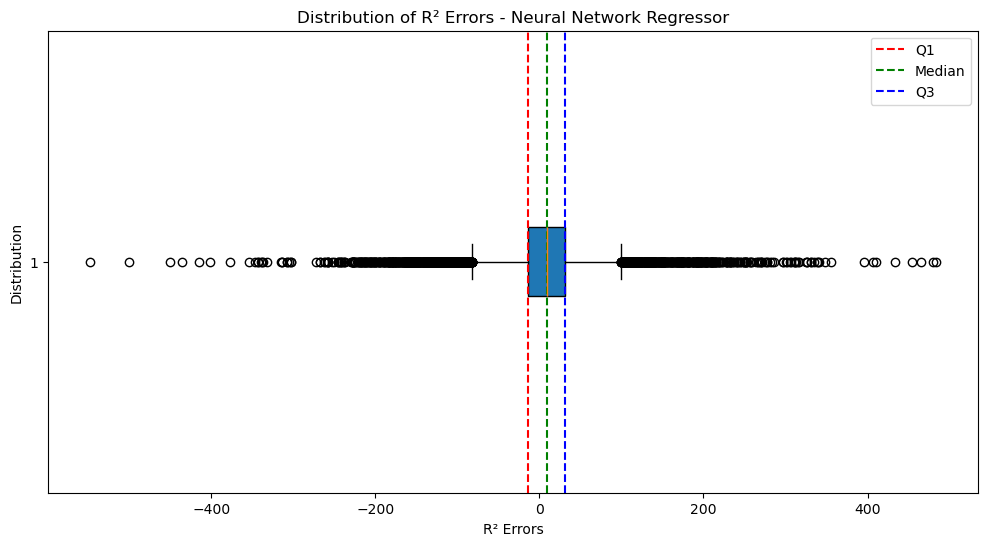

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_test_pred are defined elsewhere in your code
r2_errors = y_test - y_test_pred

# Histogram plot
plt.figure(figsize=(12, 8))
sns.histplot(r2_errors, kde=True)
plt.xlabel('R² Errors')
plt.ylabel('Frequency')
plt.title('Distribution of R² Errors - Neural Network Regressor')
plt.show()

# Boxplot with quartiles
quartiles = np.percentile(r2_errors, [25, 50, 75])

plt.figure(figsize=(12, 6))
plt.boxplot(r2_errors, vert=False, patch_artist=True)

plt.axvline(x=quartiles[0], color='red', linestyle='--', label='Q1')
plt.axvline(x=quartiles[1], color='green', linestyle='--', label='Median')
plt.axvline(x=quartiles[2], color='blue', linestyle='--', label='Q3')

plt.xlabel('R² Errors')
plt.ylabel('Distribution')
plt.title('Distribution of R² Errors - Neural Network Regressor')
plt.legend()
plt.show()


In [14]:
r2_errors.describe () 

count    22448.000000
mean         7.817019
std         50.694567
min       -547.233062
25%        -13.843744
50%          9.295751
75%         31.497551
max        483.260021
Name: price, dtype: float64

## Summary and conclusions:
In this notebook we ran an algorithm called Neural Network Regressor. In order to achieve optimal results, we performed a network search for the best parameters in 5 main components of the model:

Activation function - the activation function used by the neurons in the network

alpha - the disturbance rate that affects how much the model is updated in each iteration during training

hidden_layer_sizes - the number of neurons in each hidden layer in the network

learning_rate - check if the rate of the disturbance should change throughout the training time

Overall, it can be said that the model achieved excellent results
('Test R2': 0.98, 'Test RMSE': 51.52, 'Test MSE': 2630, 'Test MAE': 34.3)
With a very nice balance between the training and the test, it can be assumed that there is no overtraining


The conclusion here as in the other models is that the addition of the new features helped to improve the results. Both increased the R2 score and reduced the average error by half
(MAE without the new features we added - 70.6,
compared to 34.3 with the new features we added).

It can be said that this is one of the best models for forecasting holiday prices, if not the best.

Regarding the distribution of errors, it can be seen that they are more or less normally distributed.

